# CLTV PREDİCTİON

**Bir müşterinin bir firmayla olan tüm ilişki süresi boyunca firmadan yapacağı satın almaların beklenen karının bugünkü değerini göz önünde bulunduran müşteri yasam boyu değeri, işletmelerin en yüksek ve en düşük karlı müşterilerini tanımlayarak pazarlama strateji ve taktiklerine bu doğrultuda yön vermesini sağlayan bir ölçümdür.**

**CLTV nin gelecek periytlar için tahmin edilerek müşterielr hakkında geleceğe yönelik kararlar da alınabilir. CLTV Predction yaparken BG-NBD ve Gama Gama modellerini kullanırız.**

## ADIM 1.
* ### *BG-NBD (Beta Geometric Negative Binomial Distribution) model*
  *  Frequency, Recency ve Tenur değişkenleri ile BGNBD  modelini eğitiyoruz
  *  Zamana göre beklenen satın alma miktarlarını tahmin etmeye yönelik
  
## ADIM 2. 
* ### *Gama Gama  model*
  *  frequency ve monetary_avg değişkenleri ile gama-gama moelini eğitiyoruz
  *  Bekelenen Ortalama getiriyi tahmin etmeye yönelik
  
## ADIM 3. 
* ### *BG-NBD model ve Gama Gama model ile Zamana göre CLTV tahmini yapılması
   * İki model bir araya getirilerek Rececny, Frequency, Tenur(müşteri yaşı) ve Monetarty değerleri ile istenen zamana göre tahminleme yapılır

In [1]:
######################################################################
# Gerekli kütüphaneler, fonksiyonlat ve veri setini import ettim
#######################################################################
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

import time
import datetime
from datetime import timedelta


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# İleriki adımlarda kullanmak için iki tane fonksiyon yazdım: 1. aykırı değerleri yakalıyor, 2. ise aykırı değerleri sınır değerlerine baskılamaktadır.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)# %1'inci değer
    quartile3 = dataframe[variable].quantile(0.99)# %99'uncu değer
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



In [4]:
df_ = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")


In [5]:
df = df_.copy()

# Veri Ön İşleme

In [6]:
#Veriyi inceledim
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [7]:
#Verideki nan değerlerin oldğu gözlemleri attım
df.dropna(inplace=True)

# Veride C harfi içeren İnvoice'leirn buulunduğu gözlemleri attım. C harfi içereknelr iade olduğunu ifade etmekte
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0] # her işlemlde en az bir adet ürün almış olnları seçtim


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.00000,13.02179,180.41998,1.00000,2.00000,6.00000,12.00000,80995.00000
Price,397925.00000,3.11621,22.09677,0.00000,1.25000,1.95000,3.75000,8142.75000
Customer ID,397925.00000,15294.30860,1713.17274,12346.00000,13969.00000,15159.00000,16795.00000,18287.00000


Text(0.5, 1.0, 'Price')

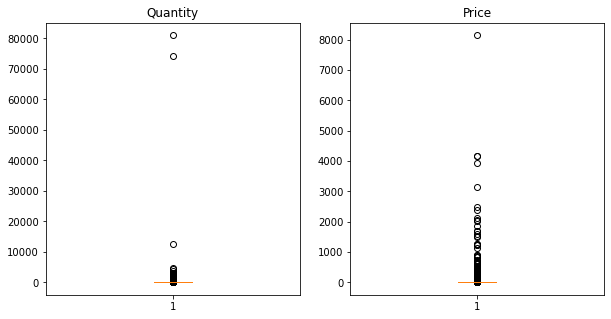

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].boxplot(df["Quantity"]);
ax[0].set_title("Quantity")
ax[1].boxplot(df["Price"]);
ax[1].set_title("Price")

In [10]:
replace_with_thresholds(df, "Quantity") # Miktarda büyük aykırı değerleri üst limit olarak belirlenen değere baskıladı
replace_with_thresholds(df, "Price") #Price da büyük aykırı değerleri üst limit olarak belirlenen değere baskıladı

Text(0.5, 1.0, 'Price')

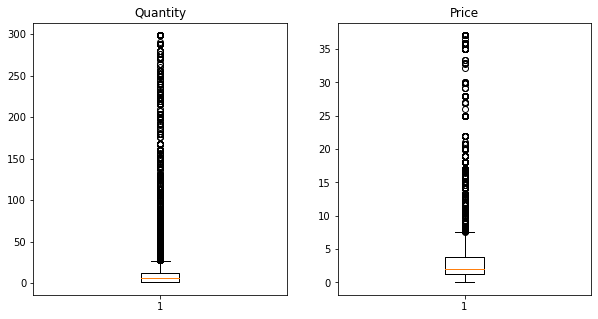

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].boxplot(df["Quantity"]);
ax[0].set_title("Quantity")
ax[1].boxplot(df["Price"]);
ax[1].set_title("Price")

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.00000,11.83371,25.53449,1.00000,2.00000,6.00000,12.00000,298.50000
Price,397925.00000,2.89320,3.22714,0.00000,1.25000,1.95000,3.75000,37.06000
Customer ID,397925.00000,15294.30860,1713.17274,12346.00000,13969.00000,15159.00000,16795.00000,18287.00000


In [13]:
# Hangi Ülkeden Kaç Müşteri Var
df["Country"].value_counts()

United Kingdom          354345
Germany                   9042
France                    8343
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

In [14]:
# Analiz Yaparken UK müşterileriyle devam etmek istedim. 
df = df[df["Country"] =="United Kingdom"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


### Bu aşamaya kadar oluşan son veriyi inceleyelim

In [15]:
df["TotalPrice"] = df["Quantity"] * df["Price"] # alınan ürünlerin toplam miktarı ile fiyatı çarpıldı. her bir ürün alımında  ne kadar para bırakıldı.
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000
1,536365,71053,WHITE METAL LANTERN,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000


In [16]:
 #Veri setinde en son işlem yapılan tarihten 2 gün sonrası referans alınarak işlemlere devam edilecek
today_date =df["InvoiceDate"].max()+timedelta(days=2)
today_date

Timestamp('2011-12-11 12:49:00')

# RFM Tablosunun Hazırlanması

In [17]:
rfm  = df.groupby("Customer ID").agg({"InvoiceDate":[lambda date:(today_date-date.max()).days,lambda date:(today_date-date.min()).days],
                                      "Invoice": lambda x: x.nunique(),
                                      "TotalPrice":lambda  x: x.sum()})

rfm.columns = rfm.columns.droplevel(0)
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']

#Her brr müşteri alışveriş başına ortalma bıraktığı para
rfm["monetary"] = rfm["monetary"] / rfm["frequency"] 
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

#Recency değerini günlükten haftalığa çevirdim
rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7 
# Tenur değerini günlükten haftalığa çevirdim
rfm["T_weekly"] = rfm["T"] / 7 

# hiç para bırakmayanları çıkardım
rfm = rfm[rfm["monetary_avg"] > 0] 
# İki defadan az alışveriş yapanları çıkardım
rfm = rfm[(rfm['frequency'] > 1)]
# Frequnecyi değerini integere çevirdim
rfm["frequency"] = rfm["frequency"].astype(int) 


In [18]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly
Customer ID,,,,,,
12747.00000,3,370,11,381.45545,0.42857,52.85714
12748.00000,2,375,210,154.19243,0.28571,53.57143
12749.00000,5,214,5,815.58800,0.71429,30.57143
12820.00000,4,328,4,235.58500,0.57143,46.85714
12822.00000,72,88,2,474.44000,10.28571,12.57143


# 2. BG/NBD Modeli

#### Modelin Kurulması

In [19]:
# bgf model nesnesini oluşturdum
bgf = BetaGeoFitter(penalizer_coef=0.001) 

# Frequency, Recency ve Tenur değişkenleri ile BGNBD  modelini eğitiyoruz
bgf.fit(rfm['frequency'], rfm['recency_weekly_p'], rfm['T_weekly'])


<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 1.71, alpha: 0.08, b: 6.60, r: 0.38>

#### Müşterilerin 1 hafta içinde beklenen satınalma değerleri

In [20]:
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
# Tahmin edeerken "conditional_expected_number_of_purchases_up_to_time" veya da "predict" fonksiyonlarının ikisi de kullanılabilir.

one_week = bgf.conditional_expected_number_of_purchases_up_to_time(1,  # Periyot, haftalık
                                                                rfm['frequency'], # Frequency
                                                                rfm['recency_weekly_p'],  # Recency
                                                                rfm['T_weekly']) #Tenur

one_week.sort_values(ascending=False).head(10)

Customer ID
16000.00000   2.94069
15060.00000   1.83808
18139.00000   1.72391
14126.00000   1.06561
16479.00000   1.01255
17772.00000   0.94211
17852.00000   0.88087
14893.00000   0.81179
15872.00000   0.73723
16343.00000   0.69925
dtype: float64

#### 1, 3 6 12 ay içinde beklenen satınalma miktarları

In [21]:
# 1 aylık
m_1=bgf.predict(4,# Haftalık periyot ile 4 hafta
            rfm['frequency'], # Frequency
            rfm['recency_weekly_p'], #Recency
            rfm['T_weekly']) # Tennur
# 3 aylık
m_3=bgf.predict(12,rfm['frequency'],rfm['recency_weekly_p'],rfm['T_weekly'])
# 6 aylık
m_6=bgf.predict(24,rfm['frequency'],rfm['recency_weekly_p'],rfm['T_weekly'])
# 12 aylık
m_12=bgf.predict(48,rfm['frequency'],rfm['recency_weekly_p'],rfm['T_weekly'])


In [22]:
# Periyotlara göre beklenen satınalmaları birleştirip inceleyelim. Haftalık olarak büyükten küçüğe doğru sıralayıp birşeltirdim
predict_df = pd.DataFrame(one_week).merge(pd.DataFrame(m_1),how="inner",on="Customer ID").sort_values("0_x",ascending=False)
predict_df = predict_df.merge(pd.DataFrame(m_3), how="inner",on="Customer ID")
predict_df = predict_df.merge(pd.DataFrame(m_6), how="inner",on="Customer ID")
predict_df = predict_df.merge(pd.DataFrame(m_12), how="inner",on="Customer ID")
predict_df.reset_index(inplace=True)
predict_df.columns=["Customer ID","W_1","m_1","m_3","m_6","m_12"]

In [23]:
predict_df.head()

,Customer ID,W_1,m_1,m_3,m_6,m_12
0,16000.00000,2.94069,6.29070,8.78526,9.91903,10.70687
1,15060.00000,1.83808,4.77154,7.65508,9.18323,10.32500
2,18139.00000,1.72391,4.97662,8.78116,11.03142,12.80821
3,14126.00000,1.06561,2.99355,5.19079,6.49340,7.53637
4,16479.00000,1.01255,2.91981,5.23900,6.70666,7.94466


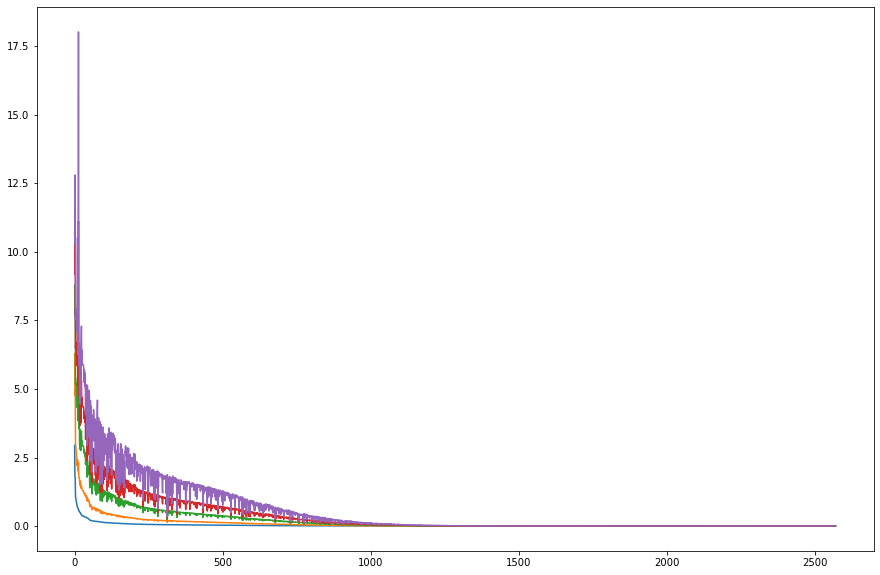

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
for col in predict_df.columns[1:]:
    ax.plot(predict_df.index,predict_df[col])

#### 1 Ay içinde tüm Şirketin Beklenen Satış Sayısı Nedir?


In [25]:
# Bütün müşterilern 1 aylık beklenen satışlarıı topluyoruz.
bgf.predict(4, rfm['frequency'],rfm['recency_weekly_p'], rfm['T_weekly']).sum()           

242.02847312369622

#### Tahmin Sonuçlarının Değerlendirilmesi

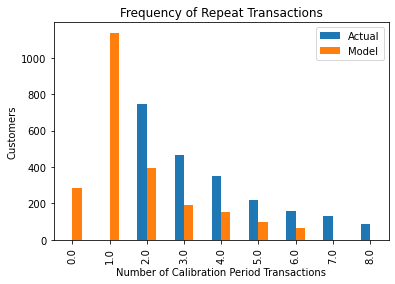

In [26]:
plot_period_transactions(bgf)
plt.show()

# 3. GAMMA-GAMMA Modelinin Kurulması,

#### Modelin Kurulması

In [27]:
# ggf model nesnesini oluşturdum
ggf = GammaGammaFitter(penalizer_coef=0.01)

# veri setindeki frequency ve monetary_avg değişkenleri ile gama-gama moelini eğittim
ggf.fit(rfm['frequency'], rfm['monetary_avg']) 


<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.81, q: 0.35, v: 3.75>

#### Beklenen Ortalama Getirinin Tahmin Edilmesi

In [28]:
ggf.conditional_expected_average_profit(rfm['frequency'],
                                           rfm['monetary_avg']).head(10)


Customer ID
12747.00000   387.82809
12748.00000   154.33601
12749.00000   845.25944
12820.00000   247.09031
12822.00000   520.87001
12823.00000   365.14361
12826.00000   216.50114
12827.00000   153.37969
12828.00000   175.41138
12829.00000   159.09328
dtype: float64

In [29]:
# Beklenne ortalama getiri
rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'], rfm['monetary_avg'])
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_average_profit
Customer ID,,,,,,,
12747.00000,3,370,11,381.45545,0.42857,52.85714,387.82809
12748.00000,2,375,210,154.19243,0.28571,53.57143,154.33601
12749.00000,5,214,5,815.58800,0.71429,30.57143,845.25944
12820.00000,4,328,4,235.58500,0.57143,46.85714,247.09031
12822.00000,72,88,2,474.44000,10.28571,12.57143,520.87001


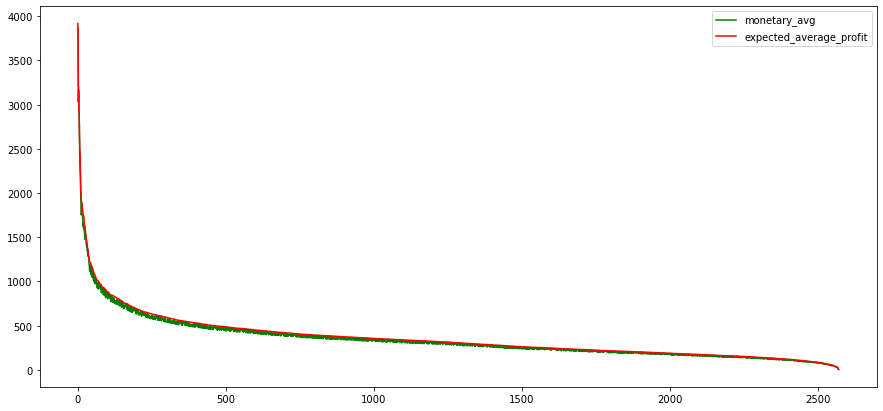

In [30]:
# Beklenen ortalama getiri ile ortalama gerçek getiriyi inceleyelim
rfm_vis=rfm.sort_values("expected_average_profit",ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(rfm_vis.index,rfm_vis["monetary_avg"],color="green",label="monetary_avg")
ax.plot(rfm_vis.index,rfm_vis["expected_average_profit"],color='red',label="expected_average_profit")
ax.legend()


In [31]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_average_profit
Customer ID,,,,,,,
12747.00000,3,370,11,381.45545,0.42857,52.85714,387.82809
12748.00000,2,375,210,154.19243,0.28571,53.57143,154.33601
12749.00000,5,214,5,815.58800,0.71429,30.57143,845.25944
12820.00000,4,328,4,235.58500,0.57143,46.85714,247.09031
12822.00000,72,88,2,474.44000,10.28571,12.57143,520.87001


# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

### Zamana Göre CLTV Tahmini Yapılması

In [32]:
# 1 aylık CLTV Tahmini
cltv_M1= ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=1,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)
rfm["clv_M1"]=cltv_M1

In [33]:
# 6 aylık CLTV Tahmini
cltv_M6 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

rfm["clv_M6"]=cltv_M6

In [34]:
# 12 aylık CLTV Tahmini
cltv_M12 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=12,  # 12 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

rfm["clv_M12"]=cltv_M12

In [35]:
rfm.sort_values(by="clv_M12", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_average_profit,clv_M1,clv_M6,clv_M12
Customer ID,,,,,,,,,,
16000.00000,4,4,3,2335.12000,0.57143,0.57143,2477.66406,15944.77066,24427.84521,26130.10969
18139.00000,19,19,6,1406.39000,2.71429,2.71429,1448.31142,7517.47858,15970.79969,18239.89730
17084.00000,36,36,2,1474.87500,5.14286,5.14286,1614.88842,2115.20800,6924.87877,9165.47954
17509.00000,59,64,8,764.39250,8.42857,9.14286,781.57525,1996.33219,6295.23391,8098.89806
16984.00000,89,131,2,2240.67500,12.71429,18.71429,2452.32343,804.16870,3684.14352,5787.53396
15749.00000,236,333,3,3028.78000,33.71429,47.57143,3213.27392,582.13476,2989.06948,5099.20267
14893.00000,11,13,2,618.92500,1.57143,1.85714,678.87053,1720.07048,4004.97116,4730.75971
17100.00000,19,19,2,485.87000,2.71429,2.71429,533.36921,1136.99235,3008.69133,3691.48206
13952.00000,219,240,2,1625.53550,31.28571,34.28571,1779.64211,400.46314,2019.12184,3398.44856


<ipython-input-36-5539be488410>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem).index.astype("str"), rotation=90)


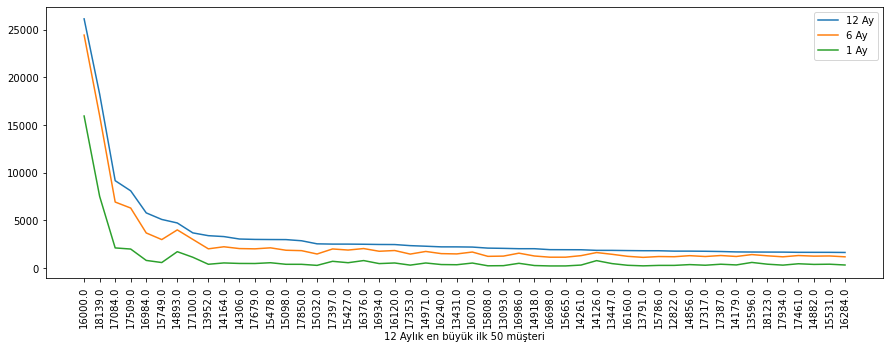

In [36]:
# 12 aylık en yüksek clvye sahip müşterilerin 12 aylık, 6 aylık  ve 1 aylık clv lerinin grafiği
gözlem = 50 # en yüksek ilk 50 müşteri
index_20=pd.DataFrame(range(0,gözlem)) # 0-20 arasında  oluşturdum
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem).index.astype("str"),rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem),label="12 Ay")
ax.plot(rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem).index.astype("str"),rfm.sort_values(by="clv_M12", ascending =False)["clv_M6"].head(gözlem),label="6 Ay")
ax.plot(rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem).index.astype("str"),rfm.sort_values(by="clv_M12", ascending =False)["clv_M1"].head(gözlem),label="1 Ay")
#ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["monetary_avg"].head(gözlem))
leg = ax.legend();
ax.set_xlabel(f"12 Aylık en büyük ilk {gözlem} müşteri")
ax.set_xticklabels(rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem).index.astype("str"), rotation=90)
plt.show()

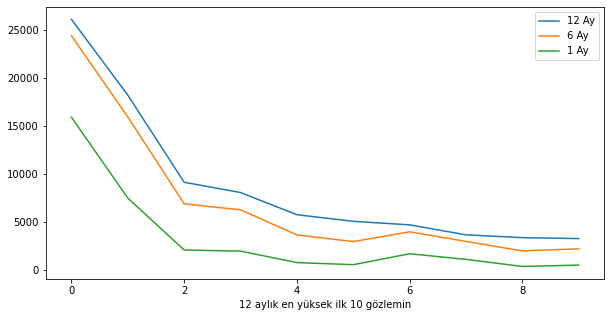

In [37]:
# 12 aylık en yüksek clvye sahip müşterilerin 12 aylık, 6 aylık  ve 1 aylık clv lerinin grafiği
gözlem = 10
index_20=pd.DataFrame(range(0,gözlem)) # 0-20 arasında  oluşturdum
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["clv_M12"].head(gözlem),label="12 Ay")
ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["clv_M6"].head(gözlem),label="6 Ay")
ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["clv_M1"].head(gözlem),label="1 Ay")
#ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["monetary_avg"].head(gözlem))
leg = ax.legend();
ax.set_xlabel(f"12 aylık en yüksek ilk {gözlem} gözlemin")
plt.show()

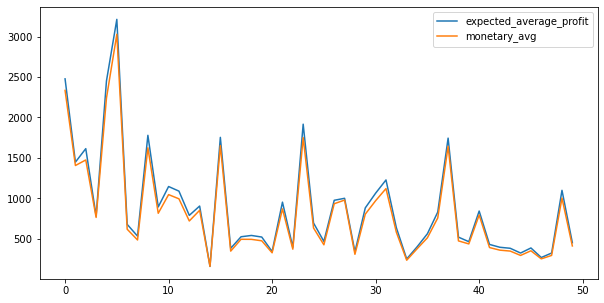

In [48]:
# ortalama getiri  ve beklenen ortalama getiri
gözlem = 50
index_20=pd.DataFrame(range(0,gözlem))
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["expected_average_profit"].head(gözlem),label="expected_average_profit")
ax.plot(index_20[0],rfm.sort_values(by="clv_M12", ascending =False)["monetary_avg"].head(gözlem),label="monetary_avg")
ax.legend()
plt.show()

## 6 Aylık CLTV'ye Göre Müşterileri Segmentlere Ayırma


<AxesSubplot:>

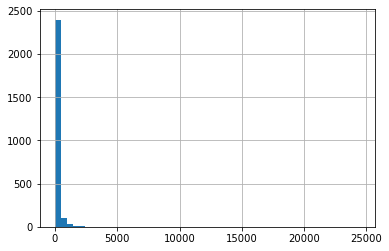

In [39]:
rfm["clv_M6"].hist(bins=50)

<AxesSubplot:ylabel='clv_M6'>

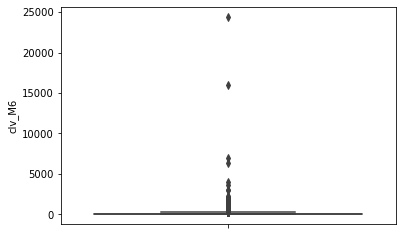

In [40]:
sns.boxplot(y=rfm["clv_M6"])

In [50]:
replace_with_thresholds(rfm,"clv_M6")

<AxesSubplot:>

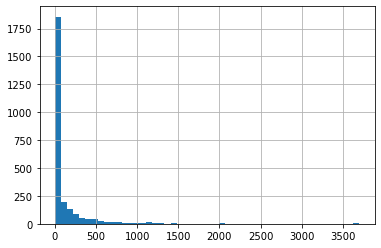

In [51]:
rfm["clv_M6"].hist(bins=50)

<AxesSubplot:ylabel='clv_M6'>

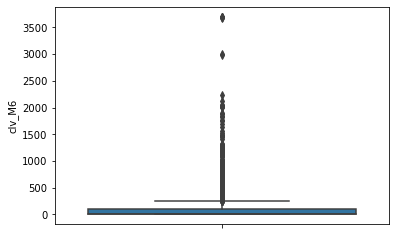

In [52]:
sns.boxplot(y=rfm["clv_M6"])

In [56]:
# 6 aylık cltv tahminlerine göre müşterileri A B C D segmenlerine ayırıyorum
rfm["Segment"] = pd.qcut(rfm["clv_M6"],4,labels = ["D","C","B","A"] )

In [57]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_average_profit,clv_M1,clv_M6,clv_M12,Segment
Customer ID,,,,,,,,,,,
12747.00000,3,370,11,381.45545,0.42857,52.85714,387.82809,0.00000,0.00000,0.00000,D
12748.00000,2,375,210,154.19243,0.28571,53.57143,154.33601,0.00000,0.00000,0.00000,D
12749.00000,5,214,5,815.58800,0.71429,30.57143,845.25944,0.00001,0.00005,0.00008,D
12820.00000,4,328,4,235.58500,0.57143,46.85714,247.09031,0.00000,0.00002,0.00003,D
12822.00000,72,88,2,474.44000,10.28571,12.57143,520.87001,283.06546,1191.40525,1777.29433,A


<AxesSubplot:xlabel='Segment', ylabel='clv_M6'>

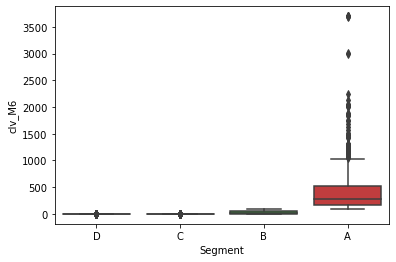

In [58]:
sns.boxplot(x="Segment",y="clv_M6", data=rfm)

#### BEST % 20 Müşterilere 1 eiteketi

In [81]:
# 6 aylık CLV'si en iyi müşterilerin %20'sini 1  olarak etiketleyelim
best_percent_20 = rfm.sort_values(by="clv_M6", ascending =False).head(int(rfm.shape[0]*0.2)).index
rfm["top_flag"] =[1 if i  in best_percent_20 else 0 for i in rfm.index]

In [77]:
rfm[rfm["top_flag"]==1]["clv_M6"].sum()/rfm["clv_M6"].sum()*100

88.35718598443367

<AxesSubplot:xlabel='top_flag', ylabel='clv_M6'>

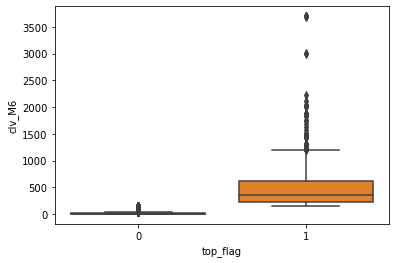

In [88]:
sns.boxplot("top_flag","clv_M6", data = rfm)

<AxesSubplot:xlabel='Segment', ylabel='clv_M6'>

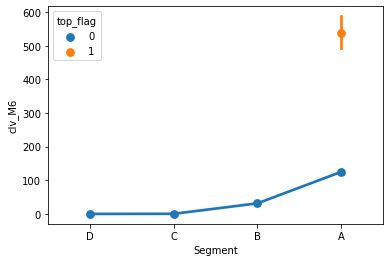

In [91]:
sns.pointplot("Segment","clv_M6", data = rfm, hue="top_flag")